<a href="https://colab.research.google.com/github/aman200-4/Real-time-Attention-Emotion-Analyzer/blob/main/Real-time-Attention-Emotion-Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe opencv-python fer


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from fer import FER


  if event.key is 'enter':



In [16]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]


Saving download (1).jpeg to download (1).jpeg


In [17]:
# STEP 4: Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

In [18]:
 #STEP 5: Eye landmark indices
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

def get_eye_aspect_ratio(landmarks, eye_indices, img_w, img_h):
    coords = [(int(landmarks[i].x * img_w), int(landmarks[i].y * img_h)) for i in eye_indices]
    vertical_1 = np.linalg.norm(np.array(coords[1]) - np.array(coords[5]))
    vertical_2 = np.linalg.norm(np.array(coords[2]) - np.array(coords[4]))
    horizontal = np.linalg.norm(np.array(coords[0]) - np.array(coords[3]))
    ear = (vertical_1 + vertical_2) / (2.0 * horizontal)
    return ear


In [19]:
# STEP 6: Read and convert image
image = cv2.imread(filename)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = rgb_image.shape
results = face_mesh.process(rgb_image)

In [20]:
# STEP 7: Predict emotion using FER
detector = FER(mtcnn=True)
emotion_results = detector.detect_emotions(rgb_image)
emotion_status = "No face/emotion detected"
if emotion_results:
    top_emotion, score = detector.top_emotion(rgb_image)
    emotion_status = f"{top_emotion.capitalize()} ({score*100:.1f}%)"


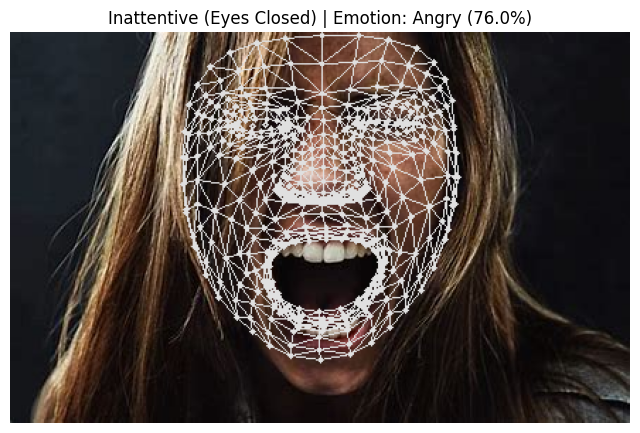

In [21]:
# STEP 8: Predict attention using EAR
attention_status = "Face Not Detected"
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        left_ear = get_eye_aspect_ratio(face_landmarks.landmark, LEFT_EYE, w, h)
        right_ear = get_eye_aspect_ratio(face_landmarks.landmark, RIGHT_EYE, w, h)
        avg_ear = (left_ear + right_ear) / 2.0
        attention_status = "Attentive (Eyes Open)" if avg_ear >= 0.2 else "Inattentive (Eyes Closed)"
        mp_drawing.draw_landmarks(rgb_image, face_landmarks, mp_face_mesh.FACEMESH_TESSELATION, drawing_spec, drawing_spec)

# STEP 9: Display results
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.axis('off')
plt.title(f'{attention_status} | Emotion: {emotion_status}')
plt.show()


In [22]:
import random

time_points = [f"T{i}" for i in range(30)]
attention_scores = [random.choice([1, 1, 1, 0]) for _ in range(30)]

attention_df = pd.DataFrame({'Time': time_points, 'Attention': attention_scores})
attention_df.head()


,Time,Attention
0,T0,1
1,T1,0
2,T2,1
3,T3,1
4,T4,1


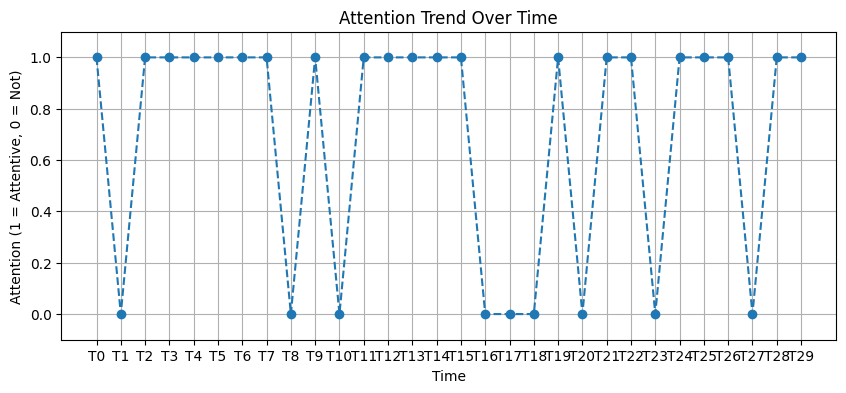

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(attention_df['Time'], attention_df['Attention'], marker='o', linestyle='--')
plt.ylim(-0.1, 1.1)
plt.title("Attention Trend Over Time")
plt.xlabel("Time")
plt.ylabel("Attention (1 = Attentive, 0 = Not)")
plt.grid(True)
plt.show()


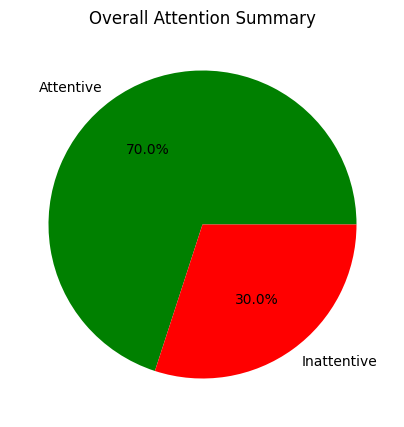

In [24]:
counts = attention_df['Attention'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=['Attentive', 'Inattentive'], colors=['green', 'red'], autopct='%1.1f%%')
plt.title("Overall Attention Summary")
plt.show()


In [25]:
attention_df.to_csv('attention_log.csv', index=False)
print("Saved to attention_log.csv")


Saved to attention_log.csv


In [26]:
import sqlite3

conn = sqlite3.connect('attention_logs.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS attention (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    time TEXT,
    attention INTEGER
)
''')

for _, row in attention_df.iterrows():
    cursor.execute('INSERT INTO attention (time, attention) VALUES (?, ?)', (row['Time'], row['Attention']))

conn.commit()
print("Data inserted into SQLite database!")


Data inserted into SQLite database!


In [27]:
cursor.execute('SELECT * FROM attention LIMIT 5')
rows = cursor.fetchall()
for row in rows:
    print(row)

conn.close()


(1, 'T0', 1)
(2, 'T1', 1)
(3, 'T2', 0)
(4, 'T3', 0)
(5, 'T4', 0)


In [28]:
# Unit 5: Save Prediction Log

# Sample log - already created from Unit 4
log_df = pd.DataFrame([{
    "Student": "Test_Student",
    "Attention_Status": attention_status
}])

# Save to CSV file
log_df.to_csv("attention_log.csv", index=False)

# Allow user to download the file
from google.colab import files
files.download("attention_log.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>